In [1]:
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


In [2]:
#整合买卖信号
def  allsingal(df):
    df['buy_signal']=np.where((df['buy_signal']==1) & (df['buy_signal'].shift(1) ==1) ,0,df['buy_signal'])#只保留第一个信号
    df['sell_signal']=np.where((df['sell_signal']==-1) & (df['sell_signal'].shift(1) ==-1) ,0,df['sell_signal'])
    df['signal']=df['buy_signal']+df['sell_signal']
    df.drop([ 'buy_signal','sell_signal'],axis=1) 
    return df            #返回整合买卖信号的df


In [3]:
#按照每笔交易计算收益率(而非每日净值)
def cal_r(df):
    df=df[df['signal'] !=0 ]             #时间序列变成了仅交易日序列
    df['r']=df['收盘'].pct_change()  #收益率:当天交易收盘价-上一次交易收盘价/当天交易收盘价
    df=df[df['signal'] ==-1 ]          #时间序列变成了仅卖出日序列
    df['cumr']=(1+df['r']).cumprod() - 1   #按照每笔交易计算累计收益率
    return df


In [4]:
#双均线策略
def ma_strategy(df, short_window=10, long_window=60):
    #计算长短均线
    df['short_ma']=df['涨跌幅'].rolling(short_window).mean()
    df['long_ma']=df['涨跌幅'].rolling(long_window).mean()
    #生成买卖信号
    df['buy_signal']=np.where((df['short_ma']>df['long_ma']),1,0)
    df['sell_signal']=np.where((df['short_ma']<df['long_ma']),-1,0)
    #整合信号
    df=allsingal(df) 
    df=df[df['signal'] !=0 ] 
    return df[['收盘','short_ma','long_ma','signal']]  


In [9]:
#使用策略并计算收益率
end_date=datetime.now().strftime("%Y%m%d")
start_date = (datetime.now()- timedelta(days=365)).strftime("%Y%m%d")
df=ak.stock_zh_a_hist("002594", start_date=start_date , end_date=end_date,period="daily", adjust="")             #获取数据开始时间比想测试时间更早1个long_window
df.set_index('日期', inplace=True)
df_ma=ma_strategy(df)
df_ma_r=cal_r(df_ma)
print("开仓次数:",len(df_ma_r))
print(df_ma)
print(df_ma_r)


开仓次数: 12
                收盘  short_ma   long_ma  signal
日期                                            
2024-07-25  250.39    -0.085  0.239167      -1
2024-08-20  236.48     0.331  0.230500       1
2024-09-23  250.00    -0.102  0.019500      -1
2024-09-24  254.29     0.119  0.043167       1
2024-10-21  306.45     0.054  0.301500      -1
2024-10-30  305.55     0.544  0.375000       1
2024-10-31  293.19     0.152  0.342167      -1
2024-12-12  283.68     0.333  0.246333       1
2024-12-13  276.51     0.071  0.147833      -1
2024-12-19  285.40     0.371  0.218833       1
2024-12-20  280.20     0.007  0.183667      -1
2024-12-25  285.92     0.196  0.173167       1
2024-12-26  284.86     0.055  0.123833      -1
2024-12-27  286.28     0.358  0.043333       1
2025-01-02  271.10    -0.473 -0.181167      -1
2025-01-16  272.76     0.071 -0.193500       1
2025-02-28  361.82     0.191  0.449000      -1
2025-03-17  380.25     0.575  0.520000       1
2025-03-21  372.00     0.481  0.481833      -1
2025

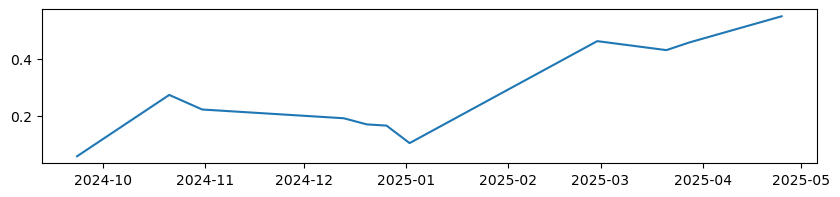

In [11]:
plt.rcParams["figure.figsize"] = [10, 2] 
plt.plot(df_ma_r.index,df_ma_r['cumr']) 

(array([2., 0., 3., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-0.05302501, -0.04037371, -0.0277224 , -0.01507109, -0.00241979,
         0.01023152,  0.02288282,  0.03553413,  0.04818543,  0.06083674,
         0.07348804,  0.08613935,  0.09879065,  0.11144196,  0.12409327,
         0.13674457,  0.14939588,  0.16204718,  0.17469849,  0.18734979,
         0.2000011 ,  0.2126524 ,  0.22530371,  0.23795501,  0.25060632,
         0.26325762,  0.27590893,  0.28856024,  0.30121154,  0.31386285,
         0.32651415]),
 <BarContainer object of 30 artists>)

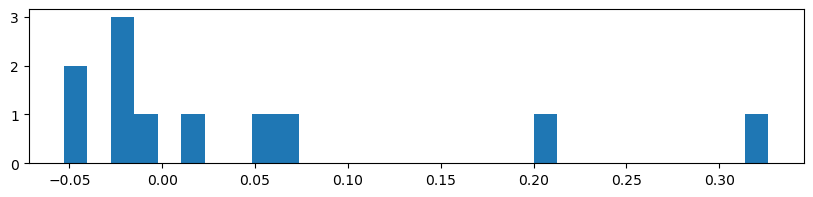

In [41]:
returns=df_ma_r['r']     #获取每笔交易收益率并观察分布情况
plt.hist(returns,bins=30) 

In [43]:
from scipy.stats import ttest_1samp
t,p=ttest_1samp(returns,0,nan_policy="omit") #检验收益是否显著大于0  忽略空缺值
p_value=p/2                              #单边检测p/2
print("使用显著水平0.05，当t>0，p_value<0.05时说明收益显著大于0, t和p_value值为:")
print(t , p_value, "是否显著大于0:",p_value<0.05)


使用显著水平0.05，当t>0，p_value<0.05时说明收益显著大于0, t和p_value值为:
1.3024551519175098 0.11097878254144337 是否显著大于0: False


In [19]:
#测试不使用策略股票被动收益
def pass_r(df):
    returns = df['涨跌幅'] / 100            
    avg_return=returns.mean()           #日平均收益                  
    year_return=avg_return*242                #不考虑复利的年化收益率
    total_return = (1 + returns).prod() - 1  # 每日累计收益
    cagr = (1 + total_return) ** (242 / len(df)) - 1  # 累计收益折算年化
    b_price,s_price = df["收盘"].iloc[0], df["收盘"].iloc[-1]
    buy_hold_return = (s_price - b_price) / b_price       #这段时间买入股票持有不动的收益率
    return  avg_return,year_return, cagr,buy_hold_return


In [21]:
pass_r(df)


(0.002272427983539095,
 0.5499275720164609,
 0.6149390641428474,
 0.6035775589484145)

(array([ 1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  4.,  3.,  3., 12., 20.,
        40., 36., 37., 24., 19.,  8.,  8., 10.,  3.,  3.,  3.,  3.,  0.,
         0.,  2.,  0.,  1.]),
 array([-0.1       , -0.09333333, -0.08666667, -0.08      , -0.07333333,
        -0.06666667, -0.06      , -0.05333333, -0.04666667, -0.04      ,
        -0.03333333, -0.02666667, -0.02      , -0.01333333, -0.00666667,
         0.        ,  0.00666667,  0.01333333,  0.02      ,  0.02666667,
         0.03333333,  0.04      ,  0.04666667,  0.05333333,  0.06      ,
         0.06666667,  0.07333333,  0.08      ,  0.08666667,  0.09333333,
         0.1       ]),
 <BarContainer object of 30 artists>)

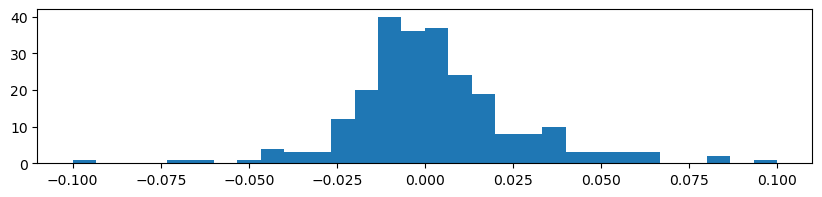

In [57]:
returns2=df['涨跌幅'] / 100   #获取每日收益率并查看其分布
plt.hist(returns2,bins=30) 

In [59]:
t2,p2=ttest_1samp(returns2,0,nan_policy="omit") #检验收益是否显著大于0  忽略空缺值
p_value2=p2/2                              #单边检测p/2
print("使用显著水平0.05，当t>0，p_value<0.05时说明收益显著大于0, t和p_value值为:")
print(t2 , p_value2, "是否显著大于0:",p_value2<0.05)


使用显著水平0.05，当t>0，p_value<0.05时说明收益显著大于0, t和p_value值为:
1.4628532989075678 0.0724025225673038 是否显著大于0: False


In [61]:
from scipy.stats import kurtosis, skew, jarque_bera

In [63]:
kurtosis(returns2, fisher=True)

2.8915954090850127

In [65]:
skew(returns2)

0.40193729183682503